by Shashwat Amit Parikh

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 44.6 MB/s eta 0:00:00:00:0100:01


# Configuration and Setup

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import rasterio

MODEL_PATH = '/kaggle/input/superresolution-sap/pytorch/default/1/best_model.pth' 
SCALE = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_RESIDUAL_BLOCKS = 32 
NUM_FEATURES = 128       
RES_SCALE = 0.1


class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_du = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.conv_du(self.avg_pool(x))

class RCABlock(nn.Module):
    def __init__(self, channels, res_scale=1.0):
        super(RCABlock, self).__init__()
        self.res_scale = res_scale
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.ca = ChannelAttention(channels)
    def forward(self, x):
        res = self.ca(self.conv2(self.relu(self.conv1(x))))
        return x + res * self.res_scale

class UpsampleBlock(nn.Module):
    def __init__(self, channels):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.relu(self.conv(x))

class EDSR_Advanced(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_features=128, num_blocks=32):
        super(EDSR_Advanced, self).__init__()
        self.conv_first = nn.Conv2d(in_channels, num_features, kernel_size=3, padding=1)
        self.body = nn.ModuleList([RCABlock(num_features, res_scale=RES_SCALE) for _ in range(num_blocks)])
        self.conv_after_body = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        self.upsample1 = UpsampleBlock(num_features)
        self.upsample2 = UpsampleBlock(num_features)
        self.conv_refine = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        self.relu_refine = nn.ReLU(inplace=True)
        self.conv_last = nn.Conv2d(num_features, out_channels, kernel_size=3, padding=1)

    def forward(self, lr_input):
        h, w = lr_input.shape[2], lr_input.shape[3]
        bicubic_base = F.interpolate(lr_input, size=(h*SCALE, w*SCALE), mode='bicubic', align_corners=False)
        x = self.conv_first(lr_input)
        res = x
        for block in self.body:
            res = block(res)
        res = self.conv_after_body(res)
        x = x + res 
        x = self.upsample2(self.upsample1(x))
        x = self.relu_refine(self.conv_refine(x))
        learned_residual = self.conv_last(x)
        return bicubic_base + learned_residual


def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return 100
    return 20 * np.log10(1.0 / np.sqrt(mse))

def calculate_ssim_np(img1, img2):
    C1, C2 = 0.01**2, 0.03**2
    mu1, mu2 = img1.mean(), img2.mean()
    sigma1_sq, sigma2_sq = img1.var(), img2.var()
    sigma12 = np.cov(img1.flatten(), img2.flatten())[0, 1]
    
    numerator = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)
    denominator = (mu1**2 + mu2**2 + C1) * (sigma1_sq + sigma2_sq + C2)
    return numerator / denominator

def load_any_image(path):
    try:
        with rasterio.open(path) as ds:
            if ds.count >= 3:
                img = np.stack([ds.read(1), ds.read(2), ds.read(3)], axis=2).astype(np.float32)
                # Normalize based on bit depth
                img_min, img_max = img.min(), img.max()
                if img_max > img_min:
                    img = (img - img_min) / (img_max - img_min)
                return img
    except Exception:
        pass
    
    img = Image.open(path).convert('RGB')
    return np.array(img).astype(np.float32) / 255.0

def run_full_inference(lr_path, hr_path=None):
    # Load model
    model = EDSR_Advanced(num_features=NUM_FEATURES, num_blocks=NUM_RESIDUAL_BLOCKS).to(DEVICE)
    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        model.eval()
    else:
        print("Error: Model weights not found.")
        return

    # Process Input
    lr_img = load_any_image(lr_path)
    lr_tensor = torch.from_numpy(lr_img).permute(2, 0, 1).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        sr_tensor = model(lr_tensor).cpu().squeeze(0).clamp(0, 1)
    
    sr_img = sr_tensor.permute(1, 2, 0).numpy()
    
    # Bicubic Baseline
    h, w, _ = lr_img.shape
    bicubic_img = np.array(Image.fromarray((lr_img * 255).astype(np.uint8)).resize((w*SCALE, h*SCALE), Image.BICUBIC)).astype(np.float32) / 255.0

    # Optional HR loading for metrics
    hr_img = None
    if hr_path and os.path.exists(hr_path):
        hr_img = load_any_image(hr_path)
        # Ensure sizes match
        if hr_img.shape != sr_img.shape:
            hr_img = np.array(Image.fromarray((hr_img * 255).astype(np.uint8)).resize((sr_img.shape[1], sr_img.shape[0]), Image.LANCZOS)).astype(np.float32) / 255.0

    # Plotting
    fig, axes = plt.subplots(1, 3 + (1 if hr_img is not None else 0), figsize=(25, 8))
    
    axes[0].imshow(lr_img)
    axes[0].set_title(f"Input LR\n({w}x{h})")
    
    axes[1].imshow(bicubic_img)
    bi_title = "Bicubic (4x)"
    if hr_img is not None:
        bi_title += f"\nP:{calculate_psnr(bicubic_img, hr_img):.2f} S:{calculate_ssim_np(bicubic_img, hr_img):.3f}"
    axes[1].set_title(bi_title)
    
    axes[2].imshow(sr_img)
    sr_title = "EDSR Advanced (4x)"
    if hr_img is not None:
        sr_title += f"\nP:{calculate_psnr(sr_img, hr_img):.2f} S:{calculate_ssim_np(sr_img, hr_img):.3f}"
    axes[2].set_title(sr_title)
    
    if hr_img is not None:
        axes[3].imshow(hr_img)
        axes[3].set_title("Ground Truth HR")

    for ax in axes: ax.axis('off')
    plt.tight_layout()
    plt.show()


# Execution

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


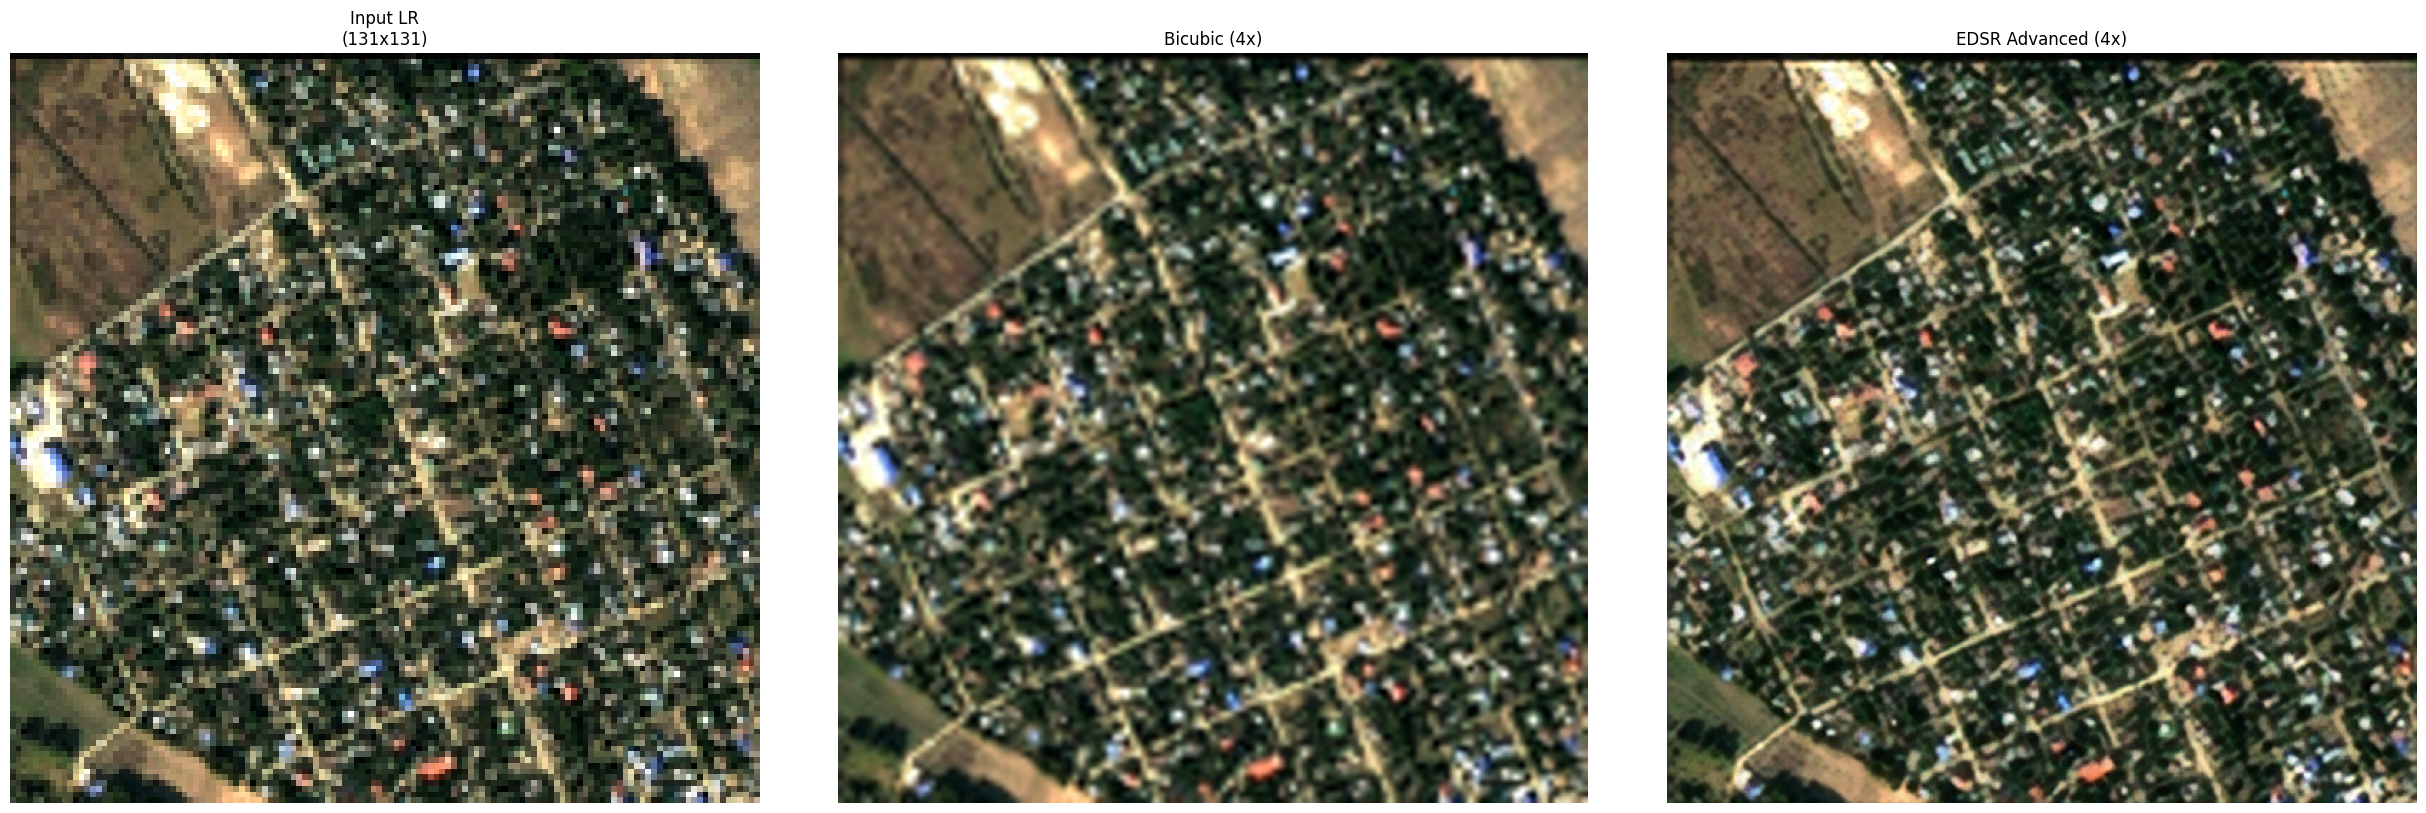

In [3]:
# Example usage:
run_full_inference('/kaggle/input/lr-images/UNHCR-3645_raw_aug1_p1_LR.tiff')